# Projekt - model klasyfikacyjny

Cel projektu: Stworzenie systemu do alertów (progonozowanie czy wypożyczeń będzie więcej niż zwrotów).
Alert powinien dotyczy kolejnej godziny. Tak, aby móc wysłać pracowników w rejony z niedoborem rowerów i przewieźć tam rezerwowe rowery lub pojazdów z innych lokalizacji.

Zadania do realizacji
1. Data preprocessing:
    - Pobranie danych
    - Wstępne sprawdzenie danych.
    - Stworzenie nowej zmiennej kategorycznej (y): Czy liczba wypożyczeń w bieżącej godzinie jest większa niż liczba zwrotów.
    - Stworzenie zmiennych z daty: godzina,miesiąc, kwartał.
    - Enkoding zmiennej departure name
    - Stworzenie lagów (wartości z poprzednich okresów):
        - wartości dla danej stacji z poprzedniej godziny
        - średnie wartości dla stacji z poprzedniego dnia
        - średnie wartości ogółu z poprzedniego dnia i godziny
    - Selekcja zmiennych
    - Detekcja outlierów.
2. Optymalizacja modelu:
    - Wykorzystanie jednego z poznanych algorytmów optymalizacyjnych.
    - W przypadku niezadowalających wyników, testy na innym algorytmie.

In [1]:
import pandas as pd

1. Data preprocessing
- Pobranie danych

In [2]:
# Wczytanie danych - liczba wypożyczeń
import os 
os.chdir('../')
df_dep = pd.read_parquet('data/hourly_data_per_station.parquet')
df_dep =  df_dep[df_dep['departure_date_hours']>='2018-01-01'].reset_index(drop=True)


In [3]:
# Wczytanie danych - liczba zwrotów
df_ret = pd.read_parquet('data/hourly_data_per_station_returns.parquet')
df_ret =  df_ret[df_ret['return_date_hours']>='2018-01-01'].reset_index(drop=True)

- Wstępne sprawdzenie danych.

In [4]:
# head
df_dep.head()

,departure_name,departure_date_hours,numbers_of_departures,distance (m),duration (sec.),avg_speed (km/h),Air temperature (degC)
0,A.I. Virtasen aukio,2019-06-26 15:00:00,2,1767.0,632.5,0.167693,17.40
1,A.I. Virtasen aukio,2019-06-26 16:00:00,1,3710.0,954.0,0.233333,17.70
2,A.I. Virtasen aukio,2019-06-26 17:00:00,2,2860.0,1154.0,0.162976,17.15
3,A.I. Virtasen aukio,2019-06-26 18:00:00,1,1792.0,396.0,0.271515,16.60
4,A.I. Virtasen aukio,2019-06-26 19:00:00,2,3641.0,917.0,0.236449,15.55


In [5]:
# head
df_ret.head()

,return_name,return_date_hours,number_of_returns,distance (m),duration (sec.),avg_speed (km/h),Air temperature (degC)
0,09 Erottaja,2018-04-16 14:00:00,1,3685.000000,1265.000000,0.174783,8.300000
1,A.I. Virtasen aukio,2019-06-26 14:00:00,2,5092.000000,1854.000000,0.164744,18.100000
2,A.I. Virtasen aukio,2019-06-26 16:00:00,1,1909.000000,835.000000,0.137174,17.400000
3,A.I. Virtasen aukio,2019-06-26 17:00:00,3,3539.666667,924.666667,0.239560,17.700000
4,A.I. Virtasen aukio,2019-06-26 19:00:00,3,1150.333333,472.000000,0.141537,15.566667


In [6]:
# info
df_dep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410972 entries, 0 to 2410971
Data columns (total 7 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   departure_name          object        
 1   departure_date_hours    datetime64[ns]
 2   numbers_of_departures   int64         
 3   distance (m)            float64       
 4   duration (sec.)         float64       
 5   avg_speed (km/h)        float64       
 6   Air temperature (degC)  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 128.8+ MB


In [7]:
# info
df_ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2442494 entries, 0 to 2442493
Data columns (total 7 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   return_name             object        
 1   return_date_hours       datetime64[ns]
 2   number_of_returns       int64         
 3   distance (m)            float64       
 4   duration (sec.)         float64       
 5   avg_speed (km/h)        float64       
 6   Air temperature (degC)  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 130.4+ MB


In [8]:
df_dep['hour'] = df_dep['departure_date_hours'].dt.hour
df_dep['day'] = df_dep['departure_date_hours'].dt.day
df_dep['month'] = df_dep['departure_date_hours'].dt.month
df_dep['quarter'] = df_dep['departure_date_hours'].dt.quarter

- Stworzenie nowej zmiennej kategorycznej (y): Czy liczba wypożyczeń w bieżącej godzinie jest większa niż liczba zwrotów.

In [9]:
# polaczenie danych
df_merged = df_dep.merge(df_ret,
                         left_on = ['departure_name','departure_date_hours'],
                         right_on=['return_name','return_date_hours'],
                         how = 'outer',
                         suffixes=('_dep','_ret'))

In [10]:
# wielkosci poszczegolnych ramek
print(df_dep.shape)
print(df_ret.shape)
print(df_merged.shape)

(2410972, 11)
(2442494, 7)
(2955057, 18)


In [11]:
df_merged.isna().sum()

departure_name                544085
departure_date_hours          544085
numbers_of_departures         544085
distance (m)_dep              544085
duration (sec.)_dep           544085
avg_speed (km/h)_dep          544382
Air temperature (degC)_dep    546027
hour                          544085
day                           544085
month                         544085
quarter                       544085
return_name                   512563
return_date_hours             512563
number_of_returns             512563
distance (m)_ret              512563
duration (sec.)_ret           512563
avg_speed (km/h)_ret          512926
Air temperature (degC)_ret    514659
dtype: int64

In [12]:
# imputacja danych
df_merged['departure_name'] = df_merged['departure_name'].fillna(df_merged['return_name'])
df_merged['departure_date_hours'] = df_merged['departure_date_hours'].fillna(df_merged['return_date_hours'])
df_merged['Air temperature (degC)'] = df_merged['Air temperature (degC)_dep'].fillna(df_merged['Air temperature (degC)_ret'])

In [13]:
df_merged.isna().sum()

departure_name                     0
departure_date_hours               0
numbers_of_departures         544085
distance (m)_dep              544085
duration (sec.)_dep           544085
avg_speed (km/h)_dep          544382
Air temperature (degC)_dep    546027
hour                          544085
day                           544085
month                         544085
quarter                       544085
return_name                   512563
return_date_hours             512563
number_of_returns             512563
distance (m)_ret              512563
duration (sec.)_ret           512563
avg_speed (km/h)_ret          512926
Air temperature (degC)_ret    514659
Air temperature (degC)          1915
dtype: int64

In [14]:
df_ret.isna().max()

return_name               False
return_date_hours         False
number_of_returns         False
distance (m)              False
duration (sec.)           False
avg_speed (km/h)           True
Air temperature (degC)     True
dtype: bool

In [15]:
del df_merged['return_date_hours']
del df_merged['return_name']
del df_merged['Air temperature (degC)_dep']
del df_merged['Air temperature (degC)_ret']

In [16]:
df_merged = df_merged.fillna(0)

In [17]:
# zmienna y kategoryczna
df_merged['y_cat'] = ((df_merged['numbers_of_departures'])-1> df_merged['number_of_returns']).astype(int)

In [18]:
# udział wartosci y
df_merged['y_cat'].value_counts()/df_merged.shape[0]

y_cat
0    0.789301
1    0.210699
Name: count, dtype: float64

  - Stworzenie zmiennych z daty: godzina, dzien, miesiąc, kwartał.

In [19]:
df_merged['hour'] = df_merged['departure_date_hours'].dt.hour
df_merged['day']  =df_merged['departure_date_hours'].dt.day
df_merged['month'] = df_merged['departure_date_hours'].dt.month
df_merged['quarter']= df_merged['departure_date_hours'].dt.quarter

 - Enkoding zmiennej departure name

In [20]:
from sklearn.preprocessing import TargetEncoder

In [21]:
# obiekt targetencoder
te = TargetEncoder().fit(df_merged[['departure_name']],df_merged['y_cat'])

In [22]:
# dodanie zmiennej enkodowanej
df_merged['departure_name_encoded'] = te.transform(df_merged[['departure_name']])

In [23]:
# sprawdzenie - head
df_merged.head()

,departure_name,departure_date_hours,numbers_of_departures,distance (m)_dep,duration (sec.)_dep,avg_speed (km/h)_dep,hour,day,month,quarter,number_of_returns,distance (m)_ret,duration (sec.)_ret,avg_speed (km/h)_ret,Air temperature (degC),y_cat,departure_name_encoded
0,09 Erottaja,2018-04-16 14:00:00,0.0,0.0,0.0,0.000000,14,16,4,2,1.0,3685.000000,1265.000000,0.174783,8.30,0,0.000000
1,A.I. Virtasen aukio,2019-06-26 14:00:00,0.0,0.0,0.0,0.000000,14,26,6,2,2.0,5092.000000,1854.000000,0.164744,18.10,0,0.171146
2,A.I. Virtasen aukio,2019-06-26 15:00:00,2.0,1767.0,632.5,0.167693,15,26,6,2,0.0,0.000000,0.000000,0.000000,17.40,1,0.171146
3,A.I. Virtasen aukio,2019-06-26 16:00:00,1.0,3710.0,954.0,0.233333,16,26,6,2,1.0,1909.000000,835.000000,0.137174,17.70,0,0.171146
4,A.I. Virtasen aukio,2019-06-26 17:00:00,2.0,2860.0,1154.0,0.162976,17,26,6,2,3.0,3539.666667,924.666667,0.239560,17.15,0,0.171146


- Stworzenie lagów (wartości z poprzednich okresów):

    - wartości dla danej stacji z poprzedniej godziny
    - średnie wartości dla stacji z poprzedniego dnia
    - średnie wartości ogółu z poprzedniego dnia i godziny

In [24]:
# pobranie stworzonych funkcji
from help_function import agg_data, lag_n

In [25]:
df_merged.columns

Index(['departure_name', 'departure_date_hours', 'numbers_of_departures',
       'distance (m)_dep', 'duration (sec.)_dep', 'avg_speed (km/h)_dep',
       'hour', 'day', 'month', 'quarter', 'number_of_returns',
       'distance (m)_ret', 'duration (sec.)_ret', 'avg_speed (km/h)_ret',
       'Air temperature (degC)', 'y_cat', 'departure_name_encoded'],
      dtype='object')

In [26]:
# kalkulacja lagów
lag_cols = ['numbers_of_departures',
       'distance (m)_dep', 'duration (sec.)_dep', 'avg_speed (km/h)_dep',
       'distance (m)_ret', 'duration (sec.)_ret', 'avg_speed (km/h)_ret',
       'Air temperature (degC)','number_of_returns', 'y_cat' ]

In [27]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955057 entries, 0 to 2955056
Data columns (total 17 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   departure_name          object        
 1   departure_date_hours    datetime64[ns]
 2   numbers_of_departures   float64       
 3   distance (m)_dep        float64       
 4   duration (sec.)_dep     float64       
 5   avg_speed (km/h)_dep    float64       
 6   hour                    int32         
 7   day                     int32         
 8   month                   int32         
 9   quarter                 int32         
 10  number_of_returns       float64       
 11  distance (m)_ret        float64       
 12  duration (sec.)_ret     float64       
 13  avg_speed (km/h)_ret    float64       
 14  Air temperature (degC)  float64       
 15  y_cat                   int32         
 16  departure_name_encoded  float64       
dtypes: datetime64[ns](1), float64(10), int32(5), o

In [28]:
df_merged[['numbers_of_departures','number_of_returns']] = df_merged[['numbers_of_departures','number_of_returns']].astype(int)

In [29]:
df_merged = df_merged.set_index('departure_date_hours').groupby('departure_name').resample('h').mean().reset_index()

In [30]:
del df_dep
del df_ret

In [31]:
# stworzenie daty z dokładnoscia do dnia
df_merged['departure_date'] = pd.to_datetime(df_merged['departure_date_hours'].dt.date)

In [32]:
df_merged = lag_n(df_merged,
                  'departure_name',
                  lag_cols,
                  'departure_date_hours')

In [33]:
df_merged.groupby('month')['numbers_of_departures'].sum()

month
3.0       41368.0
4.0      901334.0
5.0     1694158.0
6.0     1894975.0
7.0     1752321.0
8.0     1860661.0
9.0     1228371.0
10.0     769203.0
11.0        159.0
Name: numbers_of_departures, dtype: float64

In [34]:
import numpy as np

In [35]:
for i in [1,2,3,6,9,12,24]:
    df_merged = lag_n(df_merged,
                  'departure_name',
                  lag_cols,
                  'departure_date_hours',
                  lag_number=i)

In [36]:
######################################## DOGRAĆ TU KONWERSJĘ NA DATĘ!

In [37]:
df_merged = df_merged[df_merged.month.isin([5,6,7,8,9])]

In [38]:
df_merged.shape

(2261354, 88)

In [39]:
df_merged.groupby('hour')['numbers_of_departures'].sum()

hour
0.0     160319.0
1.0     103168.0
2.0      78898.0
3.0      52138.0
4.0      38287.0
5.0      35278.0
6.0      67297.0
7.0     197812.0
8.0     436048.0
9.0     420167.0
10.0    287516.0
11.0    298688.0
12.0    385899.0
13.0    419711.0
14.0    456011.0
15.0    543229.0
16.0    734254.0
17.0    813470.0
18.0    731148.0
19.0    626096.0
20.0    554544.0
21.0    455411.0
22.0    319527.0
23.0    215570.0
Name: numbers_of_departures, dtype: float64

In [40]:
df_merged = df_merged[(df_merged['hour']>=8) & (df_merged['hour']<=22)].reset_index(drop=True)

In [41]:
cols = ['numbers_of_departures', 
 'numbers_of_departures_lag_1',
 'numbers_of_departures_lag_2',
 'numbers_of_departures_lag_3',
 'y_cat',
 'y_cat_lag_1',
 'y_cat_lag_2',
 'y_cat_lag_3',
 'y_cat_lag_24']

In [42]:
df_merged[cols].corr()

,numbers_of_departures,numbers_of_departures_lag_1,numbers_of_departures_lag_2,numbers_of_departures_lag_3,y_cat,y_cat_lag_1,y_cat_lag_2,y_cat_lag_3,y_cat_lag_24
numbers_of_departures,1.000000,0.723063,0.589474,0.504037,0.369511,0.135831,0.102705,0.071343,0.151337
numbers_of_departures_lag_1,0.723063,1.000000,0.722630,0.587803,0.152996,0.361780,0.135138,0.101363,0.130922
numbers_of_departures_lag_2,0.589474,0.722630,1.000000,0.727756,0.117337,0.142875,0.359056,0.137401,0.107225
numbers_of_departures_lag_3,0.504037,0.587803,0.727756,1.000000,0.100566,0.108476,0.141920,0.359329,0.094276
y_cat,0.369511,0.152996,0.117337,0.100566,1.000000,0.102039,0.070372,0.041377,0.146596
y_cat_lag_1,0.135831,0.361780,0.142875,0.108476,0.102039,1.000000,0.104303,0.067832,0.117277
y_cat_lag_2,0.102705,0.135138,0.359056,0.141920,0.070372,0.104303,1.000000,0.105230,0.075932
y_cat_lag_3,0.071343,0.101363,0.137401,0.359329,0.041377,0.067832,0.105230,1.000000,0.048047
y_cat_lag_24,0.151337,0.130922,0.107225,0.094276,0.146596,0.117277,0.075932,0.048047,1.000000


In [43]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720980 entries, 0 to 1720979
Data columns (total 88 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   departure_name                 object        
 1   departure_date_hours           datetime64[ns]
 2   numbers_of_departures          float64       
 3   distance (m)_dep               float64       
 4   duration (sec.)_dep            float64       
 5   avg_speed (km/h)_dep           float64       
 6   hour                           float64       
 7   day                            float64       
 8   month                          float64       
 9   quarter                        float64       
 10  number_of_returns              float64       
 11  distance (m)_ret               float64       
 12  duration (sec.)_ret            float64       
 13  avg_speed (km/h)_ret           float64       
 14  Air temperature (degC)         float64       
 15  y_cat          

In [44]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720980 entries, 0 to 1720979
Data columns (total 88 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   departure_name                 object        
 1   departure_date_hours           datetime64[ns]
 2   numbers_of_departures          float64       
 3   distance (m)_dep               float64       
 4   duration (sec.)_dep            float64       
 5   avg_speed (km/h)_dep           float64       
 6   hour                           float64       
 7   day                            float64       
 8   month                          float64       
 9   quarter                        float64       
 10  number_of_returns              float64       
 11  distance (m)_ret               float64       
 12  duration (sec.)_ret            float64       
 13  avg_speed (km/h)_ret           float64       
 14  Air temperature (degC)         float64       
 15  y_cat          

In [45]:
df_merged.tail()

,departure_name,departure_date_hours,numbers_of_departures,distance (m)_dep,duration (sec.)_dep,avg_speed (km/h)_dep,hour,day,month,quarter,...,numbers_of_departures_lag_24,distance (m)_dep_lag_24,duration (sec.)_dep_lag_24,avg_speed (km/h)_dep_lag_24,distance (m)_ret_lag_24,duration (sec.)_ret_lag_24,avg_speed (km/h)_ret_lag_24,Air temperature (degC)_lag_24,number_of_returns_lag_24,y_cat_lag_24
1720975,Hollolantie,2020-09-30 22:00:00,2.0,3500.5,801.5,0.251954,22.0,30.0,9.0,3.0,...,0.0,0.0,0.0,0.000000,5717.0,1427.0,0.240378,13.2,1.0,0.0
1720976,Oravannahkatori,2020-09-30 22:00:00,0.0,0.0,0.0,0.000000,22.0,30.0,9.0,3.0,...,0.0,0.0,0.0,0.000000,792.0,447.5,0.106316,13.2,2.0,0.0
1720977,Ida Aalbergin tie,2020-09-30 22:00:00,0.0,0.0,0.0,0.000000,22.0,30.0,9.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1720978,Mastokatu,2020-09-30 22:00:00,0.0,0.0,0.0,0.000000,22.0,30.0,9.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1720979,Koivu-Mankkaa,2020-09-30 22:00:00,0.0,0.0,0.0,0.000000,22.0,30.0,9.0,3.0,...,1.0,3434.0,853.0,0.241547,1123.0,313.0,0.215272,13.2,1.0,0.0


In [46]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720980 entries, 0 to 1720979
Data columns (total 88 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   departure_name                 object        
 1   departure_date_hours           datetime64[ns]
 2   numbers_of_departures          float64       
 3   distance (m)_dep               float64       
 4   duration (sec.)_dep            float64       
 5   avg_speed (km/h)_dep           float64       
 6   hour                           float64       
 7   day                            float64       
 8   month                          float64       
 9   quarter                        float64       
 10  number_of_returns              float64       
 11  distance (m)_ret               float64       
 12  duration (sec.)_ret            float64       
 13  avg_speed (km/h)_ret           float64       
 14  Air temperature (degC)         float64       
 15  y_cat          

In [47]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720980 entries, 0 to 1720979
Data columns (total 88 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   departure_name                 object        
 1   departure_date_hours           datetime64[ns]
 2   numbers_of_departures          float64       
 3   distance (m)_dep               float64       
 4   duration (sec.)_dep            float64       
 5   avg_speed (km/h)_dep           float64       
 6   hour                           float64       
 7   day                            float64       
 8   month                          float64       
 9   quarter                        float64       
 10  number_of_returns              float64       
 11  distance (m)_ret               float64       
 12  duration (sec.)_ret            float64       
 13  avg_speed (km/h)_ret           float64       
 14  Air temperature (degC)         float64       
 15  y_cat          

In [48]:
df_merged = df_merged.reset_index(drop=True)

In [49]:
df_merged.columns

Index(['departure_name', 'departure_date_hours', 'numbers_of_departures',
       'distance (m)_dep', 'duration (sec.)_dep', 'avg_speed (km/h)_dep',
       'hour', 'day', 'month', 'quarter', 'number_of_returns',
       'distance (m)_ret', 'duration (sec.)_ret', 'avg_speed (km/h)_ret',
       'Air temperature (degC)', 'y_cat', 'departure_name_encoded',
       'departure_date', 'numbers_of_departures_lag_1',
       'distance (m)_dep_lag_1', 'duration (sec.)_dep_lag_1',
       'avg_speed (km/h)_dep_lag_1', 'distance (m)_ret_lag_1',
       'duration (sec.)_ret_lag_1', 'avg_speed (km/h)_ret_lag_1',
       'Air temperature (degC)_lag_1', 'number_of_returns_lag_1',
       'y_cat_lag_1', 'numbers_of_departures_lag_2', 'distance (m)_dep_lag_2',
       'duration (sec.)_dep_lag_2', 'avg_speed (km/h)_dep_lag_2',
       'distance (m)_ret_lag_2', 'duration (sec.)_ret_lag_2',
       'avg_speed (km/h)_ret_lag_2', 'Air temperature (degC)_lag_2',
       'number_of_returns_lag_2', 'y_cat_lag_2', 'numbers_

In [ ]:
# agregacja danych do dnia
# daily_data = agg_data(df_merged, 'departure_date',
#                       {'numbers_of_departures': 'sum',
#                        'number_of_returns': 'sum',
#                        'distance (m)': 'mean',
#                        'duration (sec.)': 'mean',
#                        'avg_speed (km/h)': 'mean',
#                        'Air temperature (degC)': 'mean'})

In [51]:
# daily_data.head()

In [52]:
# zmiana nazw kolumn
# daily_data.columns = ['yt_' + i for i in daily_data.columns]
# daily_data.head()

In [53]:
# wyznaczenie wczorajszej daty
# df_merged['yesterday_date'] = df_merged['departure_date'] - pd.Timedelta(days=1)

In [54]:
# połączenie ramek danych
# print(df_merged.shape)
# df_merged = df_merged.merge(daily_data,
#                             left_on='yesterday_date',
#                             right_on='yt_departure_date',
#                             how = 'left').fillna(0)
# print(df_merged.shape)

In [55]:
df_merged = df_merged.fillna(0)

In [56]:
# Stworzenie funkcji prepare data, która przetworzy ramkę danych i doda do niej wymagane zmienne do późniejszej predykcji modelu
def prepare_data(df):
    lag_cols = ['numbers_of_departures',
       'distance (m)', 'duration (sec.)', 'avg_speed (km/h)',
       'Air temperature (degC)','number_of_returns', 'y_cat' ]
    if not set(lag_cols).issubset(df.columns):
        raise KeyError('Given dataframe does not contain required fields.')
    df = lag_n(df,
                  'departure_name',
                  lag_cols,
                  'departure_date_hours')
    df['departure_date'] = pd.to_datetime(df['departure_date_hours'].dt.date)
    daily_data = agg_data(df, 'departure_date',
                      {'numbers_of_departures': 'sum',
                       'number_of_returns': 'sum',
                       'distance (m)': 'mean',
                       'duration (sec.)': 'mean',
                       'avg_speed (km/h)': 'mean',
                       'Air temperature (degC)': 'mean'})
    daily_data.columns = ['yt_' + i for i in daily_data.columns]
    df['yesterday_date'] = df['departure_date'] - pd.Timedelta(days=1)
    df = df.merge(daily_data,
                            left_on='yesterday_date',
                            right_on='yt_departure_date',
                            how = 'left').fillna(0)
    df['yesterday_date_hours'] = df['departure_date_hours']- pd.Timedelta(hours=24)
    df = df.merge(df[['numbers_of_departures',
       'distance (m)', 'duration (sec.)', 'avg_speed (km/h)',
       'Air temperature (degC)','number_of_returns', 'y_cat','departure_name','departure_date_hours']], 
                            left_on = ['departure_name','yesterday_date_hours'],
                            right_on = ['departure_name','departure_date_hours'],
                            suffixes=('','yt_st'),
                            how = 'left')
    df = df.fillna(0)
    return df
    

In [57]:
#df_merged_2 = prepare_data(df_merged[['departure_name', 'departure_date_hours', 'numbers_of_departures',
#       'distance (m)', 'duration (sec.)', 'avg_speed (km/h)',
#       'Air temperature (degC)', 'hour', 'day', 'month', 'quarter',
#       'number_of_returns', 'y_cat', 'departure_name_encoded']])

In [58]:
#df_merged_2.head()

In [59]:
df_merged.shape

(1720980, 88)

In [60]:
#df_merged_2.shape

In [61]:
#df_merged.columns == df_merged_2.columns

In [62]:
pd.set_option('display.max_columns',None)

In [63]:
#st = df_merged_2.departure_name.unique()[0]

In [64]:
#df_merged_2[df_merged_2['departure_name']==st].sort_values('departure_date_hours').head(20)

- Selekcja zmiennych

In [65]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

In [66]:
# kolumny w ramce danych
df_merged.columns

Index(['departure_name', 'departure_date_hours', 'numbers_of_departures',
       'distance (m)_dep', 'duration (sec.)_dep', 'avg_speed (km/h)_dep',
       'hour', 'day', 'month', 'quarter', 'number_of_returns',
       'distance (m)_ret', 'duration (sec.)_ret', 'avg_speed (km/h)_ret',
       'Air temperature (degC)', 'y_cat', 'departure_name_encoded',
       'departure_date', 'numbers_of_departures_lag_1',
       'distance (m)_dep_lag_1', 'duration (sec.)_dep_lag_1',
       'avg_speed (km/h)_dep_lag_1', 'distance (m)_ret_lag_1',
       'duration (sec.)_ret_lag_1', 'avg_speed (km/h)_ret_lag_1',
       'Air temperature (degC)_lag_1', 'number_of_returns_lag_1',
       'y_cat_lag_1', 'numbers_of_departures_lag_2', 'distance (m)_dep_lag_2',
       'duration (sec.)_dep_lag_2', 'avg_speed (km/h)_dep_lag_2',
       'distance (m)_ret_lag_2', 'duration (sec.)_ret_lag_2',
       'avg_speed (km/h)_ret_lag_2', 'Air temperature (degC)_lag_2',
       'number_of_returns_lag_2', 'y_cat_lag_2', 'numbers_

In [67]:
potential_x_names = ['hour', 'day', 'month', 'quarter', 'number_of_returns',
       'Air temperature (degC)',  'departure_name_encoded',
        'numbers_of_departures_lag_1',
       'distance (m)_dep_lag_1', 'duration (sec.)_dep_lag_1',
       'avg_speed (km/h)_dep_lag_1', 'distance (m)_ret_lag_1',
       'duration (sec.)_ret_lag_1', 'avg_speed (km/h)_ret_lag_1',
       'Air temperature (degC)_lag_1', 'number_of_returns_lag_1',
       'y_cat_lag_1', 'numbers_of_departures_lag_2', 'distance (m)_dep_lag_2',
       'duration (sec.)_dep_lag_2', 'avg_speed (km/h)_dep_lag_2',
       'distance (m)_ret_lag_2', 'duration (sec.)_ret_lag_2',
       'avg_speed (km/h)_ret_lag_2', 'Air temperature (degC)_lag_2',
       'number_of_returns_lag_2', 'y_cat_lag_2', 'numbers_of_departures_lag_3',
       'distance (m)_dep_lag_3', 'duration (sec.)_dep_lag_3',
       'avg_speed (km/h)_dep_lag_3', 'distance (m)_ret_lag_3',
       'duration (sec.)_ret_lag_3', 'avg_speed (km/h)_ret_lag_3',
       'Air temperature (degC)_lag_3', 'number_of_returns_lag_3',
       'y_cat_lag_3', 'numbers_of_departures_lag_6', 'distance (m)_dep_lag_6',
       'duration (sec.)_dep_lag_6', 'avg_speed (km/h)_dep_lag_6',
       'distance (m)_ret_lag_6', 'duration (sec.)_ret_lag_6',
       'avg_speed (km/h)_ret_lag_6', 'Air temperature (degC)_lag_6',
       'number_of_returns_lag_6', 'y_cat_lag_6', 'numbers_of_departures_lag_9',
       'distance (m)_dep_lag_9', 'duration (sec.)_dep_lag_9',
       'avg_speed (km/h)_dep_lag_9', 'distance (m)_ret_lag_9',
       'duration (sec.)_ret_lag_9', 'avg_speed (km/h)_ret_lag_9',
       'Air temperature (degC)_lag_9', 'number_of_returns_lag_9',
       'y_cat_lag_9', 'numbers_of_departures_lag_12',
       'distance (m)_dep_lag_12', 'duration (sec.)_dep_lag_12',
       'avg_speed (km/h)_dep_lag_12', 'distance (m)_ret_lag_12',
       'duration (sec.)_ret_lag_12', 'avg_speed (km/h)_ret_lag_12',
       'Air temperature (degC)_lag_12', 'number_of_returns_lag_12',
       'y_cat_lag_12', 'numbers_of_departures_lag_24',
       'distance (m)_dep_lag_24', 'duration (sec.)_dep_lag_24',
       'avg_speed (km/h)_dep_lag_24', 'distance (m)_ret_lag_24',
       'duration (sec.)_ret_lag_24', 'avg_speed (km/h)_ret_lag_24',
       'Air temperature (degC)_lag_24', 'number_of_returns_lag_24',
       'y_cat_lag_24']

In [68]:
# lista potencjalnych zmiennych
# potential_x_names = ['Air temperature (degC)', 'hour', 'day', 'month', 'quarter',
#                      'departure_name_encoded',
#                      'numbers_of_departures_lag_1', 'distance (m)_lag_1',
#        'duration (sec.)_lag_1', 'avg_speed (km/h)_lag_1',
#        'Air temperature (degC)_lag_1', 'number_of_returns_lag_1',
#        'y_cat_lag_1',
#        'yt_numbers_of_departures', 'yt_number_of_returns', 'yt_distance (m)',
#        'yt_duration (sec.)', 'yt_avg_speed (km/h)',
#        'yt_Air temperature (degC)',
#        'numbers_of_departuresyt_st', 'distance (m)yt_st',
#        'duration (sec.)yt_st', 'avg_speed (km/h)yt_st',
#        'Air temperature (degC)yt_st', 'number_of_returnsyt_st', 'y_catyt_st'
#        ]

In [69]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720980 entries, 0 to 1720979
Data columns (total 88 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   departure_name                 object        
 1   departure_date_hours           datetime64[ns]
 2   numbers_of_departures          float64       
 3   distance (m)_dep               float64       
 4   duration (sec.)_dep            float64       
 5   avg_speed (km/h)_dep           float64       
 6   hour                           float64       
 7   day                            float64       
 8   month                          float64       
 9   quarter                        float64       
 10  number_of_returns              float64       
 11  distance (m)_ret               float64       
 12  duration (sec.)_ret            float64       
 13  avg_speed (km/h)_ret           float64       
 14  Air temperature (degC)         float64       
 15  y_cat          

In [70]:
# selekcja zmiennych
# seq = RFE(estimator=DecisionTreeClassifier(max_depth=7, random_state=123),n_features_to_select=12).fit(
#     df_merged[potential_x_names],df_merged['y_cat'])

In [71]:
# lista finalnych zmiennych
# x_names = seq.get_feature_names_out()
# x_names


In [72]:
# df_merged[x_names].describe()

In [73]:
# df_merged[list(x_names) +['y_cat']].corr(method='spearman')

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

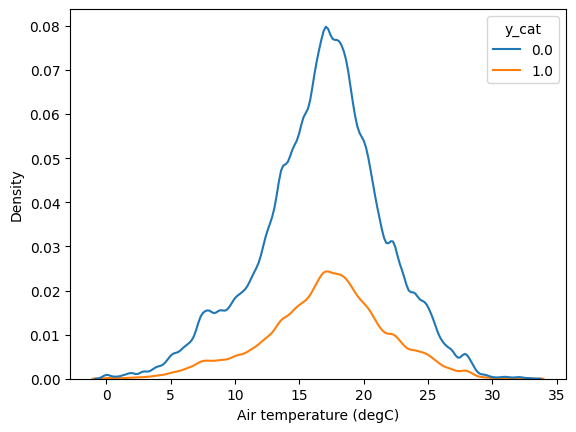

In [75]:
sns.kdeplot(data=df_merged, x='Air temperature (degC)', hue= 'y_cat')
plt.show()

In [76]:
df_merged.head()

,departure_name,departure_date_hours,numbers_of_departures,distance (m)_dep,duration (sec.)_dep,avg_speed (km/h)_dep,hour,day,month,quarter,number_of_returns,distance (m)_ret,duration (sec.)_ret,avg_speed (km/h)_ret,Air temperature (degC),y_cat,departure_name_encoded,departure_date,numbers_of_departures_lag_1,distance (m)_dep_lag_1,duration (sec.)_dep_lag_1,avg_speed (km/h)_dep_lag_1,distance (m)_ret_lag_1,duration (sec.)_ret_lag_1,avg_speed (km/h)_ret_lag_1,Air temperature (degC)_lag_1,number_of_returns_lag_1,y_cat_lag_1,numbers_of_departures_lag_2,distance (m)_dep_lag_2,duration (sec.)_dep_lag_2,avg_speed (km/h)_dep_lag_2,distance (m)_ret_lag_2,duration (sec.)_ret_lag_2,avg_speed (km/h)_ret_lag_2,Air temperature (degC)_lag_2,number_of_returns_lag_2,y_cat_lag_2,numbers_of_departures_lag_3,distance (m)_dep_lag_3,duration (sec.)_dep_lag_3,avg_speed (km/h)_dep_lag_3,distance (m)_ret_lag_3,duration (sec.)_ret_lag_3,avg_speed (km/h)_ret_lag_3,Air temperature (degC)_lag_3,number_of_returns_lag_3,y_cat_lag_3,numbers_of_departures_lag_6,distance (m)_dep_lag_6,duration (sec.)_dep_lag_6,avg_speed (km/h)_dep_lag_6,distance (m)_ret_lag_6,duration (sec.)_ret_lag_6,avg_speed (km/h)_ret_lag_6,Air temperature (degC)_lag_6,number_of_returns_lag_6,y_cat_lag_6,numbers_of_departures_lag_9,distance (m)_dep_lag_9,duration (sec.)_dep_lag_9,avg_speed (km/h)_dep_lag_9,distance (m)_ret_lag_9,duration (sec.)_ret_lag_9,avg_speed (km/h)_ret_lag_9,Air temperature (degC)_lag_9,number_of_returns_lag_9,y_cat_lag_9,numbers_of_departures_lag_12,distance (m)_dep_lag_12,duration (sec.)_dep_lag_12,avg_speed (km/h)_dep_lag_12,distance (m)_ret_lag_12,duration (sec.)_ret_lag_12,avg_speed (km/h)_ret_lag_12,Air temperature (degC)_lag_12,number_of_returns_lag_12,y_cat_lag_12,numbers_of_departures_lag_24,distance (m)_dep_lag_24,duration (sec.)_dep_lag_24,avg_speed (km/h)_dep_lag_24,distance (m)_ret_lag_24,duration (sec.)_ret_lag_24,avg_speed (km/h)_ret_lag_24,Air temperature (degC)_lag_24,number_of_returns_lag_24,y_cat_lag_24
0,Hakaniemi (M),2018-05-01 08:00:00,1.0,1053.000000,329.0,0.192036,8.0,1.0,5.0,2.0,0.0,0.00,0.0,0.000000,7.200000,0.0,0.268944,2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,2446.0,942.0,0.155796,859.0,243.0,0.212099,8.1,1.0,0.0,4.0,2227.750000,801.500000,0.175688,2094.5,645.5,0.182721,8.10,2.0,1.0,8.0,1579.125000,583.375000,0.143711,1766.142857,4269.714286,0.148940,7.812500,7.0,0.0,2.0,2922.500000,840.000000,0.191879,3359.000000,2218.000000,0.090866,6.700000,1.0,0.0,2.0,2370.0,783.500000,0.189772,1887.428571,689.142857,0.166298,6.3,7.0,0.0,2.0,792.000000,325.000000,0.147190,2899.750000,667.500000,0.241821,5.450000,4.0,0.0
1,Kustaankatu,2018-05-01 08:00:00,1.0,310.000000,94.0,0.197872,8.0,1.0,5.0,2.0,0.0,0.00,0.0,0.000000,7.200000,0.0,0.228745,2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.0,1087.0,383.0,0.171731,874.5,345.5,0.143030,8.1,2.0,0.0,3.0,2982.333333,906.333333,0.208105,2137.5,796.0,0.162122,8.50,2.0,0.0,2.0,2830.500000,926.500000,0.193043,1630.666667,515.666667,0.186832,7.700000,3.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,1027.0,425.500000,0.144818,0.000000,0.000000,0.000000,6.9,0.0,1.0,1.0,2920.000000,790.000000,0.221772,0.000000,0.000000,0.000000,4.500000,0.0,0.0
2,Näkinsilta,2018-05-01 08:00:00,0.0,0.000000,0.0,0.000000,8.0,1.0,5.0,2.0,1.0,2154.00,517.0,0.249981,7.200000,0.0,0.284796,2018-05-01,0.0,0.0,0.0,0.0,5727.0,1514.0,0.226962,8.1,1.0,0.0,1.0,1921.0,599.0,0.192421,0.0,0.0,0.000000,8.1,0.0,0.0,4.0,2024.250000,653.250000,0.154206,515.5,8781.0,0.001763,8.30,2.0,1.0,3.0,1671.333333,617.333333,0.161658,2548.666667,728.000000,0.208056,8.000000,3.0,0.0,2.0,1364.500000,598.000000,0.155164,0.000000,0.000000,0.000000,6.700000,0.0,1.0,4.0,1646.5,513.000000,0.195119,2049.400000,773.400000,0.162733,6.6,5.0,0.0,10.0,1974.867000,547.600000,0.217608,2229.250000,680.000000,0.163991,5.830000,4.0,1.0
3,Kaisaniemenpuisto,2018-05-01 08:00:00,0.0,0.000000,0.0,0.000000,8.0,1.0,5.0,2.0

- Detekcja outlierów.

In [77]:
# Definicja obiektu


In [78]:
# fit


In [79]:
# predykcja outlierów


In [80]:
# udział


In [81]:
# dodanie outlierow do danych


2. Optymalizacja modelu:
    - Wykorzystanie jednego z poznanych algorytmów optymalizacyjnych.
    - W przypadku niezadowalających wyników, testy na innym algorytmie.

In [82]:
# minimalna data dla każdej stacji
min_date = df_merged.groupby('departure_name')['departure_date'].min().reset_index().rename(
    columns={'departure_date':'min_date'})

In [83]:
min_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   departure_name  347 non-null    object        
 1   min_date        347 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 5.6+ KB


In [84]:
min_date['min_date'] = pd.to_datetime(min_date['min_date'])

In [85]:
# stacje do odrzucenia 
stations_to_exclude = min_date[min_date['min_date']>='2020-01-01']['departure_name'].values
stations_to_exclude


array(['Derby Business Park', 'Erottajan aukio', 'Kaapelitehdas',
       'Korkeasaari', 'Muotoilijankatu', 'Outotec', 'Pasilan asema'],
      dtype=object)

In [86]:
# filtrowanie
df_exclude = df_merged[~(df_merged['departure_name'].isin(stations_to_exclude))]
df_exclude.shape

(1709575, 88)

In [87]:
df_merged.shape

(1720980, 88)

In [88]:
# info
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720980 entries, 0 to 1720979
Data columns (total 88 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   departure_name                 object        
 1   departure_date_hours           datetime64[ns]
 2   numbers_of_departures          float64       
 3   distance (m)_dep               float64       
 4   duration (sec.)_dep            float64       
 5   avg_speed (km/h)_dep           float64       
 6   hour                           float64       
 7   day                            float64       
 8   month                          float64       
 9   quarter                        float64       
 10  number_of_returns              float64       
 11  distance (m)_ret               float64       
 12  duration (sec.)_ret            float64       
 13  avg_speed (km/h)_ret           float64       
 14  Air temperature (degC)         float64       
 15  y_cat          

In [89]:
date_train = '2020-01-01'
date_test = '2020-06-30'

In [90]:
df_exclude.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1709575 entries, 0 to 1720979
Data columns (total 88 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   departure_name                 object        
 1   departure_date_hours           datetime64[ns]
 2   numbers_of_departures          float64       
 3   distance (m)_dep               float64       
 4   duration (sec.)_dep            float64       
 5   avg_speed (km/h)_dep           float64       
 6   hour                           float64       
 7   day                            float64       
 8   month                          float64       
 9   quarter                        float64       
 10  number_of_returns              float64       
 11  distance (m)_ret               float64       
 12  duration (sec.)_ret            float64       
 13  avg_speed (km/h)_ret           float64       
 14  Air temperature (degC)         float64       
 15  y_cat               

In [91]:
df_exclude['departure_date'] = pd.to_datetime(df_exclude['departure_date'])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6660\226843885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exclude['departure_date'] = pd.to_datetime(df_exclude['departure_date'])


In [92]:
########### - DODAJ ŻE DANE> MIN_DATE

In [93]:
# podzial na train / test / valid
train = df_exclude[df_exclude['departure_date']<=date_train]
test = df_exclude[(df_exclude['departure_date']>date_train) & (df_exclude['departure_date']<=date_test)]
valid = df_exclude[df_exclude['departure_date']>date_test]
print(train.shape)
print(test.shape)
print(valid.shape)

(1088212, 88)
(250343, 88)
(371020, 88)


In [94]:
df_exclude['year'] = df_exclude['departure_date'].dt.year
df_exclude.groupby('year').count()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6660\1074961272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exclude['year'] = df_exclude['departure_date'].dt.year


,departure_name,departure_date_hours,numbers_of_departures,distance (m)_dep,duration (sec.)_dep,avg_speed (km/h)_dep,hour,day,month,quarter,number_of_returns,distance (m)_ret,duration (sec.)_ret,avg_speed (km/h)_ret,Air temperature (degC),y_cat,departure_name_encoded,departure_date,numbers_of_departures_lag_1,distance (m)_dep_lag_1,duration (sec.)_dep_lag_1,avg_speed (km/h)_dep_lag_1,distance (m)_ret_lag_1,duration (sec.)_ret_lag_1,avg_speed (km/h)_ret_lag_1,Air temperature (degC)_lag_1,number_of_returns_lag_1,y_cat_lag_1,numbers_of_departures_lag_2,distance (m)_dep_lag_2,duration (sec.)_dep_lag_2,avg_speed (km/h)_dep_lag_2,distance (m)_ret_lag_2,duration (sec.)_ret_lag_2,avg_speed (km/h)_ret_lag_2,Air temperature (degC)_lag_2,number_of_returns_lag_2,y_cat_lag_2,numbers_of_departures_lag_3,distance (m)_dep_lag_3,duration (sec.)_dep_lag_3,avg_speed (km/h)_dep_lag_3,distance (m)_ret_lag_3,duration (sec.)_ret_lag_3,avg_speed (km/h)_ret_lag_3,Air temperature (degC)_lag_3,number_of_returns_lag_3,y_cat_lag_3,numbers_of_departures_lag_6,distance (m)_dep_lag_6,duration (sec.)_dep_lag_6,avg_speed (km/h)_dep_lag_6,distance (m)_ret_lag_6,duration (sec.)_ret_lag_6,avg_speed (km/h)_ret_lag_6,Air temperature (degC)_lag_6,number_of_returns_lag_6,y_cat_lag_6,numbers_of_departures_lag_9,distance (m)_dep_lag_9,duration (sec.)_dep_lag_9,avg_speed (km/h)_dep_lag_9,distance (m)_ret_lag_9,duration (sec.)_ret_lag_9,avg_speed (km/h)_ret_lag_9,Air temperature (degC)_lag_9,number_of_returns_lag_9,y_cat_lag_9,numbers_of_departures_lag_12,distance (m)_dep_lag_12,duration (sec.)_dep_lag_12,avg_speed (km/h)_dep_lag_12,distance (m)_ret_lag_12,duration (sec.)_ret_lag_12,avg_speed (km/h)_ret_lag_12,Air temperature (degC)_lag_12,number_of_returns_lag_12,y_cat_lag_12,numbers_of_departures_lag_24,distance (m)_dep_lag_24,duration (sec.)_dep_lag_24,avg_speed (km/h)_dep_lag_24,distance (m)_ret_lag_24,duration (sec.)_ret_lag_24,avg_speed (km/h)_ret_lag_24,Air temperature (degC)_lag_24,number_of_returns_lag_24,y_cat_lag_24
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260,448260
2019,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952,639952
2020,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363,621363


In [95]:
train = train[train['departure_date']>='2018-01-01']
print(train.shape)

(1088212, 88)


In [96]:
# podzial na x/y
train_x = train[potential_x_names]
train_y = train['y_cat']
test_x = test[potential_x_names]
test_y = test['y_cat']
valid_x = valid[potential_x_names]
valid_y = valid['y_cat']


In [97]:
import optuna 
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

In [98]:
from sklearn.ensemble import GradientBoostingClassifier

In [99]:
def objective(trial):
    params = {'max_iter': trial.suggest_int('max_iter',200,2000),
              'max_depth': trial.suggest_int('max_depth',10,100),
              'learning_rate': trial.suggest_float('learning_rate',0.01,0.9),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf',5,500)
              }
    model = HistGradientBoostingClassifier(**params).fit(train_x,train_y)
    preds = model.predict_proba(test_x)[:,1]
    pred_train = model.predict_proba(train_x)[:,1]
    print(roc_auc_score(train_y,pred_train))
    return roc_auc_score(test_y, preds)

In [100]:
study = optuna.create_study(direction='maximize')


[I 2024-12-24 14:20:53,394] A new study created in memory with name: no-name-ca48ec80-a806-4b58-9f27-fb550a9eb272


In [101]:
study.optimize(objective,n_trials=10,n_jobs=-1)

0.8025095455861093


[I 2024-12-24 14:22:57,956] Trial 2 finished with value: 0.7676195744915154 and parameters: {'max_iter': 1812, 'max_depth': 92, 'learning_rate': 0.6871926544392725, 'min_samples_leaf': 96}. Best is trial 2 with value: 0.7676195744915154.


0.8190092439636778


[I 2024-12-24 14:26:41,723] Trial 4 finished with value: 0.7730069987457748 and parameters: {'max_iter': 1520, 'max_depth': 78, 'learning_rate': 0.4422958317496766, 'min_samples_leaf': 228}. Best is trial 4 with value: 0.7730069987457748.


0.8144701199235299


[I 2024-12-24 14:28:42,995] Trial 3 finished with value: 0.7770336128401805 and parameters: {'max_iter': 1805, 'max_depth': 42, 'learning_rate': 0.1296981792284116, 'min_samples_leaf': 43}. Best is trial 3 with value: 0.7770336128401805.


0.8030370497027368


[I 2024-12-24 14:28:52,098] Trial 5 finished with value: 0.7707171633703196 and parameters: {'max_iter': 740, 'max_depth': 28, 'learning_rate': 0.4126733043112992, 'min_samples_leaf': 301}. Best is trial 3 with value: 0.7770336128401805.


0.8297751640566715


[I 2024-12-24 14:30:00,068] Trial 0 finished with value: 0.7745166200944649 and parameters: {'max_iter': 1764, 'max_depth': 29, 'learning_rate': 0.21590865845399765, 'min_samples_leaf': 90}. Best is trial 3 with value: 0.7770336128401805.


0.8086353260709599


[I 2024-12-24 14:31:13,475] Trial 6 finished with value: 0.7698655065006782 and parameters: {'max_iter': 1696, 'max_depth': 57, 'learning_rate': 0.5957495777283071, 'min_samples_leaf': 273}. Best is trial 3 with value: 0.7770336128401805.


0.8079650547239516


[I 2024-12-24 14:31:34,500] Trial 7 finished with value: 0.7701580273376751 and parameters: {'max_iter': 431, 'max_depth': 100, 'learning_rate': 0.4908302897346924, 'min_samples_leaf': 130}. Best is trial 3 with value: 0.7770336128401805.


0.8102504894765247


[I 2024-12-24 14:32:23,830] Trial 8 finished with value: 0.7634491637087084 and parameters: {'max_iter': 347, 'max_depth': 39, 'learning_rate': 0.813374220584499, 'min_samples_leaf': 271}. Best is trial 3 with value: 0.7770336128401805.
[I 2024-12-24 14:33:06,578] Trial 9 finished with value: 0.7734331184734143 and parameters: {'max_iter': 1236, 'max_depth': 22, 'learning_rate': 0.3397611929871168, 'min_samples_leaf': 93}. Best is trial 3 with value: 0.7770336128401805.


0.8060893757882275


[I 2024-12-24 14:33:41,737] Trial 1 finished with value: 0.777702019645375 and parameters: {'max_iter': 808, 'max_depth': 53, 'learning_rate': 0.11592002126488263, 'min_samples_leaf': 53}. Best is trial 1 with value: 0.777702019645375.


0.8258254847295585


In [102]:
best_params = study.best_params


In [103]:
# final model 
final_model = HistGradientBoostingClassifier(**best_params).fit(train_x,train_y)

In [104]:
# predykcje
train_pred = final_model.predict_proba(train_x)
test_pred = final_model.predict_proba(test_x)
valid_pred = final_model.predict_proba(valid_x)

In [105]:
print(roc_auc_score(train_y,train_pred[:,1]))
print(roc_auc_score(test_y,test_pred[:,1]))
print(roc_auc_score(valid_y,valid_pred[:,1]))

0.8166999477397232
0.7766989567402711
0.7934501772387437


In [106]:
# evaluation - classification report
valid_pred_class = final_model.predict(valid_x)

In [107]:
print(classification_report(valid_y,valid_pred_class))

              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89    292287
         1.0       0.63      0.29      0.40     78733

    accuracy                           0.81    371020
   macro avg       0.73      0.62      0.64    371020
weighted avg       0.79      0.81      0.78    371020



In [108]:
results = df_exclude.loc[df_exclude['departure_date']>='2020-01-01',['y_cat','pred_proba','departure_name']].groupby('departure_name').apply(lambda x: roc_auc_score(x['y_cat'],x['pred_proba'])).reset_index()

KeyError: "['pred_proba'] not in index"

In [ ]:
results

In [ ]:
avg_no_of_dep = df_merged.loc[df_merged['departure_date']>='2020-03-01',[
    'departure_name','departure_date','numbers_of_departures']].groupby([
        'departure_name','departure_date']).sum().reset_index()[[
            'departure_name','numbers_of_departures']].groupby('departure_name').mean().reset_index()

In [83]:
# zapis modelu
